<a href="https://colab.research.google.com/github/Sylvariane/Kaggle_cryptocurrencies_forecasting/blob/main/P08_01_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly
!pip install finta

# G-Research Crypto Forecasting

Cryptocurrencies are very popular but have the disavantage to be more volatile than classical stock prices. The first cryptocurrency, Bitcoin, was created in 2008 by Satoshi Nakamoto. Bitcoin is created as a decentralized system based on the blockchain technology. However, in the next years, creation of many other cryptocurrencies has been exploded. The expansion and democratization of these methods have opened new horizons for stock market. 

In this Kaggle competition, the aim is to predict trends about cryptocurrencies by using the most well-knowledge currencies. It is important to keep in mind that forecasting stock market is a hard task and thus, forecasting trends in cryptocurrencies is more harder. 

__Datasets__

In this competition, 5 files are available : 
- A first train set,
- A supplementary train set,
- An asset set with information about cryptocurrencies,
- An example test,
- An example test submission.

Only three datasets (*the two train sets & the asset set*) were used in this exploration. 

__Configuration and Utils__

In [2]:
# Google Drive connexion
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# system libraries
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import logging
logging.disable(logging.CRITICAL)
import gc

# data manipulation libraries
import pandas as pd
import numpy as np

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# financial analysis
from finta import TA

from functools import reduce
from datetime import datetime
import time

In [4]:
def crypto_df(asset_id, data):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    df = data[data["asset_name"] == asset_id].reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df


def candelstick_chart(data, title):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    candlestick = go.Figure(data=[go.Candlestick(x=data.index,
                                                 open=data[('open')],
                                                 high=data[('high')],
                                                 low=data[('low')],
                                                 close=data[('close')])])
    candlestick.update_xaxes(title_text='Time',
                             rangeslider_visible=False)

    candlestick.update_layout(
        title={
            'text': '{:} Candelstick Chart'.format(title),
            'y': 0.90,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'})

    candlestick.update_yaxes(title_text='Price in USD', ticksuffix='$')
    return candlestick


def vol_traded(data, title, color):
    # Copied from https://www.kaggle.com/odins0n/g-research-plots-eda
    area = px.area(data_frame=data,
                   x=data.index,
                   y="volume")
    area.update_traces(line_color=color)
    area.update_xaxes(
        title_text='Time',
        rangeslider_visible=False)
    area.update_yaxes(title_text='Number of trades every minute')
    area.update_layout(showlegend=True,
                       title={
                           'text': '{:} Volume Traded'.format(title),
                           'y': 0.94,
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top'})
    return area

## 1) Preprocessing

In [5]:
# Importing datasets
df = pd.read_csv("/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/train.csv")
df_sup = pd.read_csv("/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/supplemental_train.csv")
asset = pd.read_csv("/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/asset_details.csv")
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
df.shape

(24236806, 10)

Columns of the dataset :
* timestamp - A timestamp for the minute covered by the row.
* Asset_ID - An ID code for the cryptoasset.
* Count - The number of trades that took place this minute.
* Open - The USD price at the beginning of the minute.
* High - The highest USD price during the minute.
* Low - The lowest USD price during the minute.
* Close - The USD price at the end of the minute.
* Volume - The number of cryptoasset units traded during the minute.
* VWAP - The volume weighted average price for the minute.
* Target - 15 minute residualized returns.

Target column contains values to predict ([Information about target calculus](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition?cellIds=49&kernelSessionId=78721864)). 

In [7]:
# Creating an unique df with data
df = df.append(df_sup,
               ignore_index=True,
               verify_integrity=True)

In [8]:
df.shape

(26251918, 10)

In [9]:
# Merging dataset to obtain name of each cryptocurrency
df = pd.merge(df, asset, on="Asset_ID")
df = df[["timestamp", "Asset_Name", "Count",
         "Open", "High", "Low",
         "Close", "Volume", "VWAP",
         "Target"]]
df.columns = ["timestamp", "asset_name", "count",
              "open", "high", "low",
              "close", "volume", "vwap",
              "target"]
df.head()

,timestamp,asset_name,count,open,high,low,close,volume,vwap,target
0,1514764860,Bitcoin Cash,40.0,2376.580000,2399.5,2357.14,2374.590000,19.233005,2373.116392,-0.004218
1,1514764920,Bitcoin Cash,53.0,2374.553333,2400.9,2354.20,2372.286667,24.050259,2371.434498,-0.004079
2,1514764980,Bitcoin Cash,61.0,2371.633333,2401.9,2353.70,2372.063333,42.676438,2375.442755,-0.002892
3,1514765040,Bitcoin Cash,95.0,2376.060000,2406.4,2344.00,2370.566667,37.820918,2371.096152,-0.003718
4,1514765100,Bitcoin Cash,33.0,2372.656667,2404.6,2343.40,2370.173333,8.519679,2370.345730,-0.002171


In [10]:
# Missing values exploration
df.isnull().mean() * 100

timestamp     0.000000
asset_name    0.000000
count         0.000000
open          0.000000
high          0.000000
low           0.000000
close         0.000000
volume        0.000000
vwap          0.000034
target        2.864831
dtype: float64

Only 3% of data is missing in the target column. Choice was taken to drop these data. 

In [11]:
# Deleting missing data
df.dropna(inplace=True)

## 2) Exploratory Analysis

### a) Candlestick representation

In this part, data will be visualised with the help of candlestick graphs. This kind of graph is used to see information about open, close, high and low values of a currency during a certain period of time. Here, the last 120 minutes were reprensented.
To realize the graph, a dataframe for each currency was created. Then, Plotly library was used to displayed the graphs.

In [12]:
binance = crypto_df("Binance Coin", data=df)
btc = crypto_df("Bitcoin", data=df)
btc_cash = crypto_df("Bitcoin Cash", data=df)
cardano = crypto_df("Cardano", data=df)
dogecoin = crypto_df("Dogecoin", data=df)
eos = crypto_df("EOS.IO", data=df)
eth = crypto_df("Ethereum", data=df)
eth_classic = crypto_df("Ethereum Classic", data=df)
iota = crypto_df("IOTA", data=df)
litecoin = crypto_df("Litecoin", data=df)
maker = crypto_df("Maker", data=df)
monero = crypto_df("Monero", data=df)
stellar = crypto_df("Stellar", data=df)
tron = crypto_df("TRON", data=df)

- Binance Coin

In [13]:
binance_plot = candelstick_chart(binance[-120:], title="Binance Coin")
binance_plot.show()

- Bitcoin

In [14]:
btc_plot = candelstick_chart(btc[-120:], title="Bitcoin")
btc_plot.show()

- Bitcoin Cash

In [15]:
btc_cash_plot = candelstick_chart(btc_cash[-120:], title="Bitcoin Cash")
btc_cash_plot.show()

- Cardano

In [16]:
cardano_plot = candelstick_chart(cardano[-120:], title="Cardano")
cardano_plot.show()

- Dogecoin

In [17]:
dogecoin_plot = candelstick_chart(dogecoin[-120:], title="Dogecoin")
dogecoin_plot.show()

- EOS.IO

In [18]:
eos_plot = candelstick_chart(eos[-120:], title="EOS.IO")
eos_plot.show()

- Ethereum

In [19]:
eth_plot = candelstick_chart(eth[-120:], title="Ethereum")
eth_plot.show()

- Ethereum Classic

In [20]:
eth_classic_plot = candelstick_chart(
    eth_classic[-120:], title="Ethereum Classic")
eth_classic_plot.show()

- IOTA

In [21]:
iota_plot = candelstick_chart(iota[-120:], title="IOTA")
iota_plot.show()

- Litecoin

In [22]:
litecoin_plot = candelstick_chart(litecoin[-120:], title="Litecoin")
litecoin_plot.show()

- Maker

In [23]:
maker_plot = candelstick_chart(maker[-120:], title="Maker")
maker_plot.show()

- Monero

In [24]:
monero_plot = candelstick_chart(monero[-120:], title="Monero")
monero_plot.show()

- Stellar

In [25]:
stellar_plot = candelstick_chart(stellar[-120:], title="Stellar")
stellar_plot.show()

- TRON

In [26]:
tron_plot = candelstick_chart(tron[-120:], title="TRON")
tron_plot.show()

Visually, we can conclude that some currencies are more stable than others. The ups and downs seems to follow the same series but the amplitude are variable. For instance, IOTA shows great difference between the parameters ohlc.

### b) Volume exchange

Second visualisation is about volume traded during the last 60 minutes. 

- Binance Coin

In [27]:
vol_traded(binance[-60:], "Binance Coin", color="Green")

- Bitcoin

In [28]:
vol_traded(btc[-60:], "Bitcoin", color="Blue")

- Bitcoin Cash

In [29]:
vol_traded(btc_cash[-60:], "Bitcoin Cash", color="Green")

- Cardano

In [30]:
vol_traded(cardano[-60:], "Cardano", color="Blue")

- Dogecoin

In [31]:
vol_traded(dogecoin[-60:], "Dogecoin", color="Green")

- EOS.IO

In [32]:
vol_traded(eos[-60:], "EOS.IO", color="Blue")

- Ethereum

In [33]:
vol_traded(eth[-60:], "Ethereum", color="Green")

- Ethereum Classic

In [34]:
vol_traded(eth_classic[-60:], "Ethereum Classic", color="Blue")

- IOTA

In [35]:
vol_traded(iota[-60:], "IOTA", color="Green")

- Litecoin

In [36]:
vol_traded(litecoin[-60:], "Litecoin", color="Blue")

- Maker

In [37]:
vol_traded(maker[-60:], "Maker", color="Green")

- Monero

In [38]:
vol_traded(monero[-60:], "Monero", color="Blue")

- Stellar

In [39]:
vol_traded(stellar[-60:], "Stellar", color="Green")

- TRON

In [40]:
vol_traded(tron[-60:], "TRON", color="Blue")

In [41]:
del binance_plot, btc_plot, btc_cash_plot,\
    cardano_plot, dogecoin_plot, eos_plot,\
    eth_plot, eth_classic_plot, iota_plot,\
    litecoin_plot, maker_plot, monero_plot,\
    stellar_plot, tron_plot
gc.collect()

15228

### c) Central tendency analysis

In [42]:
df.groupby("asset_name").mean()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,1.577619e+09,206.026645,97.435112,97.550453,97.314252,97.434826,1.817857e+03,97.432628,3.043179e-05
Bitcoin,1.577203e+09,1138.951031,17328.200112,17369.030215,17294.527731,17328.204983,9.203060e+01,17328.058605,-1.049945e-06
Bitcoin Cash,1.577300e+09,155.139718,500.668930,502.099341,499.222879,500.665371,2.220252e+02,500.661194,-4.663662e-06
Cardano,1.581936e+09,277.742466,0.468688,0.469567,0.467859,0.468689,3.338300e+05,0.468678,3.734066e-06
Dogecoin,1.601113e+09,571.221628,0.097294,0.097501,0.097101,0.097294,2.676080e+06,0.097293,3.103318e-05
EOS.IO,1.577285e+09,250.665842,4.863420,4.878688,4.850696,4.863411,2.797586e+04,4.863365,-1.143377e-06
Ethereum,1.577203e+09,749.697448,843.315566,845.242966,841.529544,843.316981,1.127527e+03,843.308616,-7.488925e-07
Ethereum Classic,1.577348e+09,140.063298,18.133545,18.235931,18.064507,18.133577,3.344421e+03,18.133468,3.360473e-05
IOTA,1.583003e+09,40.789458,0.676435,0.683490,0.669463,0.676437,1.571685e+04,0.676416,2.182263e-05


In [43]:
df.groupby("asset_name").median()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,1578508680,53.0,19.844800,19.863000,19.824600,19.844500,993.200000,19.843419,-0.000019
Bitcoin,1577818410,619.0,9426.790833,9442.636572,9412.785000,9426.762381,52.519000,9426.822784,-0.000019
Bitcoin Cash,1578035550,74.0,402.132917,403.050000,401.060000,402.110000,88.061216,402.127908,-0.000084
Cardano,1583231370,57.0,0.093897,0.094003,0.093788,0.093898,147745.250850,0.093898,-0.000064
Dogecoin,1606130850,28.0,0.003477,0.003480,0.003474,0.003477,541203.682763,0.003477,-0.000040
EOS.IO,1577913750,114.0,3.990220,3.996500,3.983700,3.990140,12401.530044,3.990197,-0.000073
Ethereum,1577821110,318.0,346.022083,346.670000,345.560000,346.020000,579.167816,346.018897,-0.000027
Ethereum Classic,1578041040,44.0,8.024800,8.217200,7.899100,8.024800,1186.849200,8.024570,-0.000070
IOTA,1583691480,14.0,0.437200,0.438600,0.435900,0.437200,5471.162500,0.437174,0.000000


In [44]:
df.groupby("asset_name").std()

,timestamp,count,open,high,low,close,volume,vwap,target
asset_name,,,,,,,,,
Binance Coin,3.545751e+07,442.348633,155.617483,155.806321,155.419810,155.616413,2.834458e+03,155.614282,0.005307
Bitcoin,3.549574e+07,1643.732438,15999.066761,16008.599364,15984.809843,15999.097335,1.536481e+02,15998.925243,0.001988
Bitcoin Cash,3.551466e+07,306.910178,383.897337,385.728833,381.957945,383.895901,4.599372e+02,383.889560,0.006277
Cardano,3.298165e+07,766.112276,0.716201,0.717538,0.714929,0.716205,6.108978e+05,0.716184,0.004416
Dogecoin,2.382184e+07,2026.236212,0.135372,0.135695,0.135068,0.135371,9.997040e+06,0.135370,0.007716
EOS.IO,3.545380e+07,612.094164,2.851896,2.861651,2.841999,2.851884,6.203616e+04,2.851815,0.004719
Ethereum,3.549660e+07,1276.238869,998.360903,999.539499,997.073659,998.362749,2.018844e+03,998.356130,0.002454
Ethereum Classic,3.548766e+07,532.466546,20.397819,20.519281,20.334893,20.397856,5.477800e+04,20.397795,0.008701
IOTA,3.497126e+07,150.919616,0.516153,0.524864,0.507730,0.516155,3.989869e+04,0.516131,0.008411


### d) Correlation between cryptocurrencies

In [45]:
df_close = df.copy()
df_close = df_close[["timestamp", "asset_name", "close"]]
df_close["timestamp"] = df_close["timestamp"].apply(
    lambda x: datetime.fromtimestamp(x))
df_close["date"] = df_close["timestamp"].astype('datetime64[s]')
df_close.set_index("date", inplace=True)
df_close.drop("timestamp", axis=1, inplace=True)
df_close = df_close[["asset_name", "close"]]
df_close["close"] = df_close["close"].apply(lambda x: np.log(x))

In [46]:
df_close_2021 = df_close.loc['01/01/2021':'01/06/2021']
df_close_2021.reset_index(inplace=True)
df_close_2021 = pd.pivot_table(
    df_close_2021, values="close", columns="asset_name", index="date")

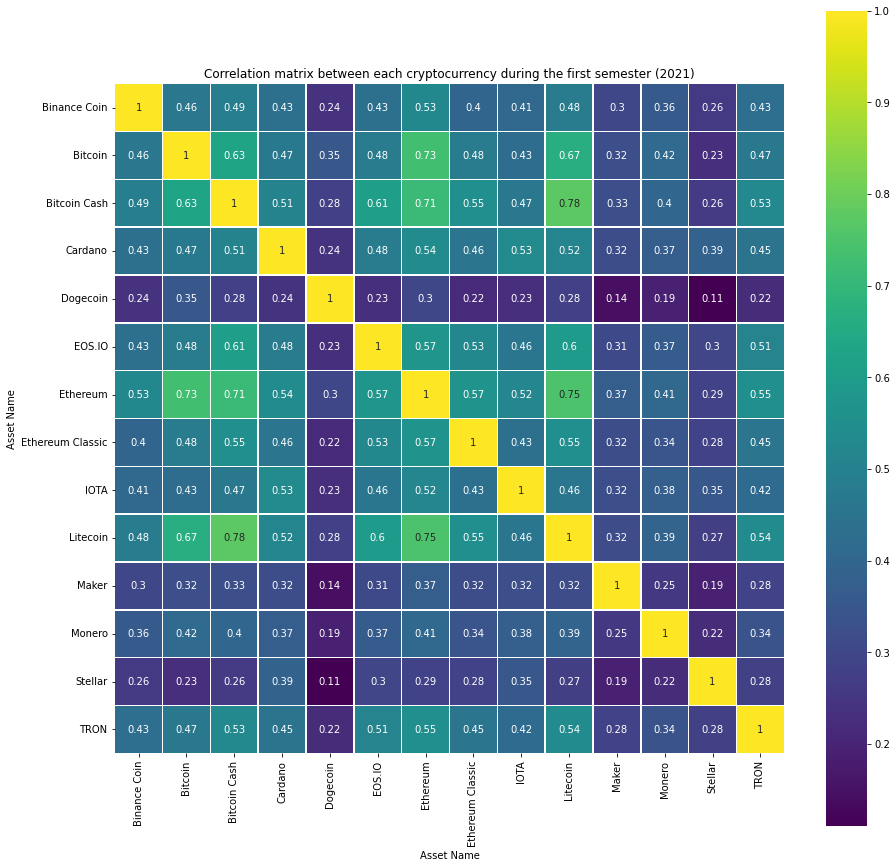

In [47]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_close_2021.diff().corr(),
            linewidths=.5,
            annot=True,
            square=True,
            cmap="viridis")
plt.xlabel("Asset Name")
plt.ylabel("Asset Name")
plt.title("Correlation matrix between each cryptocurrency during the first semester (2021)")
plt.show()

In [48]:
del df_close
del df_close_2021
gc.collect()

222062

## 3) Features Engineering

In [50]:
dataset = [binance, btc, btc_cash,
           cardano, dogecoin, eos,
           eth, eth_classic, iota,
           litecoin, maker, monero,
           stellar, tron]


cols = ['open', 'close', "high", "low"]

for i in dataset:
    for j in cols:
        i["log_"+j] = i[j].apply(lambda x: np.log(x))

### a) Creating new variables

- Variables from *Vijha et al. 2020*

1. Stock High minus Low price (H-L)
2. Stock Close minus Open price (O-C)
3. Stock price’s seven days’ moving average (7 DAYS MA)
4. Stock price’s fourteen days’ moving average (14 DAYS MA)
5. Stock price’s twenty one days’ moving average (21 DAYS MA)
6. Stock price’s standard deviation for the past seven days (7 DAYS STD DEV)

In [52]:
for i in dataset:
    i["H-L"] = i["log_high"] - i["log_low"]
    i["O-C"] = i["log_open"] - i["log_close"]
    i["MA_7d"] = i["log_close"].rolling(10080).mean()
    i["MA_14d"] = i["log_close"].rolling(20160).mean()
    i["MA_21d"] = i["log_close"].rolling(30240).mean()
    i["STD_7d"] = i["log_close"].rolling(10080).std()

- Fractal Adaptive Moving Average (FRAMA)

In [53]:
for i in dataset:
    i["FRAMA"] = TA.FRAMA(i)

- Relevant Strength Index (RSI)

In [54]:
for i in dataset:
    i["RSI"] = TA.RSI(i)

In [57]:
data = binance.append(btc)
data = data.append(btc_cash)
data = data.append(cardano)
data = data.append(dogecoin)
data = data.append(eos)
data = data.append(eth)
data = data.append(eth_classic)
data = data.append(iota)
data = data.append(litecoin)
data = data.append(maker)
data = data.append(monero)
data = data.append(stellar)
data = data.append(tron)

In [59]:
data.tail(3)

,asset_name,count,open,high,low,close,volume,vwap,target,log_open,log_close,log_high,log_low,H-L,O-C,MA_7d,MA_14d,MA_21d,STD_7d,FRAMA,RSI
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-09-20 23:42:00,TRON,527.0,0.091171,0.091295,0.091092,0.091180,2.386078e+06,0.091185,-0.002437,-2.395021,-2.394922,-2.393659,-2.395885,0.002226,-0.000099,-2.215447,-2.277176,-2.292165,0.072741,0.091055,37.878670
2021-09-20 23:43:00,TRON,463.0,0.091206,0.091290,0.091028,0.091081,1.568854e+06,0.091131,0.004843,-2.394631,-2.396006,-2.393714,-2.396588,0.002874,0.001375,-2.215461,-2.277183,-2.292164,0.072762,0.091058,35.477629
2021-09-20 23:44:00,TRON,512.0,0.090989,0.091133,0.090831,0.090885,1.900695e+06,0.090943,0.004163,-2.397021,-2.398156,-2.395435,-2.398755,0.003319,0.001135,-2.215475,-2.277189,-2.292162,0.072783,0.091039,31.251933


In [60]:
data.to_csv('/content/drive/My Drive/Ingénieur ML - OC/P8/datasets/dataset_crypto.csv', index=True)

#### b) Adding New variable

https://alternative.me/crypto/fear-and-greed-index/

__Ressources:__
- Vijha, M., Chandolab, D., Tikkiwalb V. A., Kumar, A. (2020). Stock Closing Price Prediction using Machine Learning Techniques, *Procedia Computer Science*, 167, 599-606
- Pironi, D. (2020). The Crypto Arbitrage Opportunity. https://suiteki.medium.com/the-crypto-arbitrage-opportunity-986b78740155
- Arte. (2021). Le mystère Satoshi : Aux origines du Bitcoin. https://www.youtube.com/watch?v=0ETcLj5jBy4
- Kaabar, S. (2021). Fractal Adaptative Moving Averages. The Full Guide. https://medium.com/the-investors-handbook/fractal-adaptive-moving-average-the-full-guide-c0ae348d9497